**GOAL:**  Determine if there is effect of government policy on covid mortality rate, how soon it takes effect, and whether that effect is significant.

**SUMMARY:**  A higher stringency of government policy drops the covid mortality rate with a significant effect starting 3 weeks after the policy is in place, pvalue=3.4e-128 (Benjamini Hochberg adjusted).

**Details:**

We used a mixed model to determine whether the mortality rate over 14 day intervals was affected by the stringency of government policy.  

*Best Fit Model*:  

````
Mortality Rate at date d ~ Stringency Index at date d-21 days + Mortality Rate at date d-14 days + (1|Country)
````

We obtained daily mortality rates for 170 countries from the ECDC website (1).  This data was combined with socioeconomic factors such as rates of diabetes and poverty from the "Our World in Data" data aggregator site (2) and the government response stringency indices collated by the Oxford Government Response Tracker (3).

The government response stringency indices are convenient single numerical representations of various policy measures that can be implemented by government, including testing measures, income support, and work closures.  The higher the index, the more stringent the policy.

In addition to the stringency policy, we found that poverty levels and age were significantly predictive of mortality rate, but diabetes and hospital beds per capita were not.

Mixed Models modified from analysis done by Jinjarak, Yothin, et al. 2020 (4).


**References:**

(1) European Centre For Disease Prevention And Control (2020) ‘Sonraí faoi choróinvíreas COVID-19’. Publications Office. doi: 10.2906/101099100099/1.  Retrieved from:  https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data 

(2) Max Roser, Hannah Ritchie, Esteban Ortiz-Ospina and Joe Hasell (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/coronavirus'

(3) Thomas Hale, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira. (2020). Oxford COVID-19 Government Response Tracker. Blavatnik School of Government.  Retrieved from: https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker

(4) Jinjarak, Yothin, et al.  Accounting for Global COVID-19 Diffusion Patterns, January-April 2020. No. w27185. National Bureau of Economic Research, 2020.

In [1]:
import numpy as np
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats 
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import display
from datetime import date, timedelta
import statsmodels.stats as smstats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import tools as smtools
from matplotlib.lines import Line2D

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
ecdc_csv = "data/ecdc/COVID_19_cases_worldwide.2020_07_27.csv"
owid_csv = "data/our_world_in_data/owid-covid-data.2020_07_27.csv"
oxcgrt_csv = "data/ox_govt_resp_tracker/OxCGRT_2020_07_27.csv"

# Explore ECDC Dataset


In [3]:
ecdc_df = pd.read_csv(ecdc_csv)
display(ecdc_df.shape)
display(ecdc_df.head())

(32432, 12)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,27/07/2020,27,7,2020,106,10,Afghanistan,AF,AFG,38041757.0,Asia,4.763187
1,26/07/2020,26,7,2020,121,13,Afghanistan,AF,AFG,38041757.0,Asia,4.484546
2,25/07/2020,25,7,2020,108,35,Afghanistan,AF,AFG,38041757.0,Asia,4.389913
3,24/07/2020,24,7,2020,13,0,Afghanistan,AF,AFG,38041757.0,Asia,5.309955
4,23/07/2020,23,7,2020,188,21,Afghanistan,AF,AFG,38041757.0,Asia,5.946098


In [4]:
ecdc_df["countriesAndTerritories"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua_and_Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius and Saba', 'Bosnia_and_Herzegovina',
       'Botswana', 'Brazil', 'British_Virgin_Islands',
       'Brunei_Darussalam', 'Bulgaria', 'Burkina_Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape_Verde',
       'Cases_on_an_international_conveyance_Japan', 'Cayman_Islands',
       'Central_African_Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo', 'Costa_Rica', 'Cote_dIvoire', 'Croatia',
       'Cuba', 'Curaçao', 'Cyprus', 'Czechia',
       'Democratic_Republic_of_the_Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican_Republic', 'Ecuador', 'Egypt',
       'El_Salvador', 'Equatorial_Guinea', 'Eri

In [5]:
ecdc_df["countryterritoryCode"].unique()

array(['AFG', 'ALB', 'DZA', 'AND', 'AGO', 'AIA', 'ATG', 'ARG', 'ARM',
       'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR',
       'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA',
       'BRA', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN',
       'CPV', nan, 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COM', 'COG',
       'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'COD', 'DNK',
       'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST',
       'SWZ', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'PYF', 'GAB',
       'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GUM',
       'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'VAT', 'HND', 'HUN',
       'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA',
       'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'XKX', 'KWT', 'KGZ',
       'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX',
       'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MRT', 'MUS', 'MEX',
       'MDA', '

Change all taiwan codes to TWN

In [6]:
ecdc_df["countriesAndTerritories"]  = ecdc_df["countriesAndTerritories"].str.replace("_", " ")
ecdc_df["countriesAndTerritories"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius and Saba', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cases on an international conveyance Japan', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo', 'Costa Rica', 'Cote dIvoire', 'Croatia',
       'Cuba', 'Curaçao', 'Cyprus', 'Czechia',
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eri

Modify the country codes manually so that they fit the other datasets

In [7]:
ecdc_df[ecdc_df["countriesAndTerritories"] == "Taiwan"]["countryterritoryCode"].unique()

array(['CNG1925'], dtype=object)

In [8]:
ecdc_df.loc[ecdc_df["countriesAndTerritories"] == "Taiwan", "countryterritoryCode"] = "TWN"

In [9]:
ecdc_df[ecdc_df["countryterritoryCode"] == "MSF"]["countriesAndTerritories"].unique()

array(['Montserrat'], dtype=object)

In [10]:
ecdc_df.loc[ecdc_df["countryterritoryCode"] == "MSF", "countryterritoryCode"] = "MSR"

In [11]:
ecdc_df["dateRepFormat"] = pd.to_datetime(ecdc_df["dateRep"], format='%d/%m/%Y')

In [12]:
# Sort by Country ISO Code and Date, ascending
ecdc_df = ecdc_df.sort_values(by=["countryterritoryCode", "dateRepFormat"]).reset_index(drop=True)

In [13]:
# Check that it's sorted

sorted_ecdc_df = (ecdc_df[["countryterritoryCode", "dateRepFormat"]]
                    .sort_values(by=["countryterritoryCode", "dateRepFormat"],
                                ascending=[True, True])
                     .reset_index(drop=True))

assert(sorted_ecdc_df.equals( ecdc_df[["countryterritoryCode", "dateRepFormat"]]))

In [14]:
ecdc_df["countryterritoryCode"] = ecdc_df["countryterritoryCode"].fillna("Unknown")

Check that we have data for consecutive days for every country

In [15]:
# What is the time between reports by country?
ecdc_df["time_delta"] = ecdc_df.groupby("countryterritoryCode")["dateRepFormat"].diff()
ecdc_df[["countryterritoryCode", "dateRepFormat", "time_delta"]].head()

,countryterritoryCode,dateRepFormat,time_delta
0,ABW,2020-03-13,NaT
1,ABW,2020-03-20,7 days
2,ABW,2020-03-24,4 days
3,ABW,2020-03-25,1 days
4,ABW,2020-03-26,1 days


In [16]:
def calc_time_since_first_case(df):
    case_idxs = np.argwhere(df["cases"] > 0)
    if case_idxs.shape[0] > 0:
        first_case_idx = case_idxs[0][0]
        result_df = df["dateRepFormat"] - df.iloc[first_case_idx]["dateRepFormat"]
        result_df = result_df.reset_index(drop=True)
#         print(result_df)
    else:
        print("should  never get here")
        result_df = -1

    result_df = result_df.reset_index(drop=True)
    return result_df
    

time_since_first = (ecdc_df
                   .groupby("countryterritoryCode")
                   .apply(calc_time_since_first_case))
ecdc_df["time_since_first"] = time_since_first.reset_index(drop=True)
ecdc_df["time_since_first"].describe()

count                      32432
mean     64 days 01:28:32.086827
std      50 days 15:02:07.442810
min           -62 days +00:00:00
25%             26 days 00:00:00
50%             65 days 00:00:00
75%            104 days 00:00:00
max            209 days 00:00:00
Name: time_since_first, dtype: object

In [17]:
total_cases_by_country = ecdc_df.groupby("countryterritoryCode")["cases"].sum()
total_cases_by_country = total_cases_by_country.sort_values(ascending=False)
display(total_cases_by_country.head())

countryterritoryCode
USA    4234020
BRA    2419091
IND    1435453
RUS     812485
ZAF     445433
Name: cases, dtype: int64

In [18]:
total_cases_by_country.describe()

count    2.100000e+02
mean     7.737698e+04
std      3.577402e+05
min      3.000000e+00
25%      4.500000e+02
50%      3.370500e+03
75%      3.321425e+04
max      4.234020e+06
Name: cases, dtype: float64

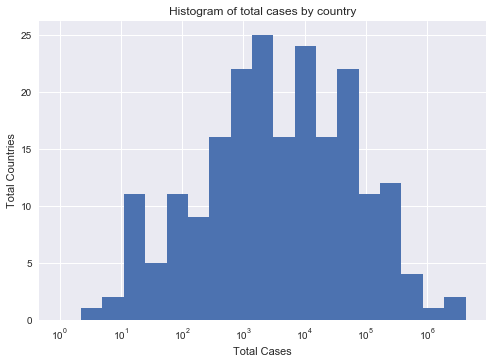

In [19]:
fig, axs  = plt.subplots()
axs.hist(total_cases_by_country, 
         bins=np.logspace(np.log10(1),np.log10(total_cases_by_country.max() + 1000), 20))
axs.set_xscale("log")
axs.set_title("Histogram of total cases by country")
axs.set_xlabel("Total Cases")
axs.set_ylabel("Total Countries")
plt.show()

In [20]:
display(total_cases_by_country[total_cases_by_country < 100].shape)
display(total_cases_by_country[total_cases_by_country < 100].head())

(26,)

countryterritoryCode
TCA    99
BTN    95
SXM    94
LIE    87
ATG    82
Name: cases, dtype: int64

In [21]:
total_deaths_by_country = ecdc_df.groupby("countryterritoryCode")["deaths"].sum()
display(total_deaths_by_country.head())

countryterritoryCode
ABW       3
AFG    1269
AGO      35
AIA       0
ALB     138
Name: deaths, dtype: int64

In [22]:
total_deaths_by_country.describe()

count       210.000000
mean       3091.466667
std       13255.040809
min           0.000000
25%           9.250000
50%          69.000000
75%         572.250000
max      146935.000000
Name: deaths, dtype: float64

In [23]:
#countries with no deaths
display(total_deaths_by_country[total_deaths_by_country == 0].shape)
display(total_deaths_by_country[total_deaths_by_country == 0].head())
# Proportion of countries with no deaths
display(total_deaths_by_country[total_deaths_by_country == 0].shape[0]/total_deaths_by_country.shape[0])

(24,)

countryterritoryCode
AIA    0
BES    0
BTN    0
DMA    0
ERI    0
Name: deaths, dtype: int64

0.11428571428571428

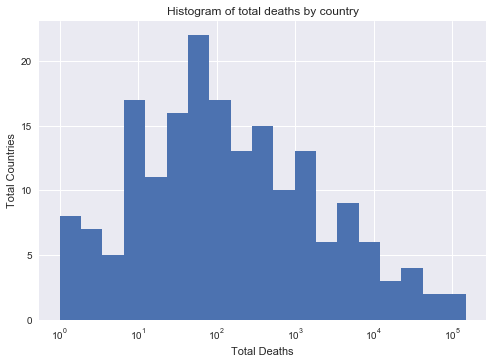

In [24]:
fig, axs  = plt.subplots()
axs.hist(total_deaths_by_country, 
         bins=np.logspace(np.log10(1),np.log10(total_deaths_by_country.max() + 1000), 20))
axs.set_xscale("log")
axs.set_title("Histogram of total deaths by country")
axs.set_xlabel("Total Deaths")
axs.set_ylabel("Total Countries")
plt.show()

In [25]:
total_days_since_first_by_country = ecdc_df.groupby("countryterritoryCode")["time_since_first"].max()
total_days_since_first_by_country = total_days_since_first_by_country.sort_values(ascending=False)
display(total_days_since_first_by_country.head())

countryterritoryCode
CHN   209 days
THA   196 days
JPN   194 days
KOR   189 days
USA   188 days
Name: time_since_first, dtype: timedelta64[ns]

Check if values make sense.

There are negative values in cumulative cases, new deahts, and new cases. From the website, this is because of data corrections.  Ideally, we would correct these values ourselves, but we will just leave them as is because they are a rare occurrence (only happens once).

In [26]:
ecdc_df.describe()

,day,month,year,cases,deaths,popData2019,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,time_delta,time_since_first
count,32432.000000,32432.000000,32432.000000,32432.000000,32432.000000,3.236800e+04,29651.000000,32222,32432
mean,15.910459,4.693821,2019.997934,501.022601,20.017514,4.502388e+07,24.877725,1 days 00:21:37.796536,64 days 01:28:32.086827
std,8.671816,1.767390,0.045405,3104.761536,122.238184,1.631451e+08,64.324748,0 days 06:48:28.846741,50 days 15:02:07.442810
min,1.000000,1.000000,2019.000000,-29726.000000,-1918.000000,8.150000e+02,-32.757608,1 days 00:00:00,-62 days +00:00:00
25%,8.000000,4.000000,2020.000000,0.000000,0.000000,1.641164e+06,0.151533,1 days 00:00:00,26 days 00:00:00
50%,16.000000,5.000000,2020.000000,5.000000,0.000000,8.544527e+06,2.955113,1 days 00:00:00,65 days 00:00:00
75%,23.000000,6.000000,2020.000000,94.000000,2.000000,3.041786e+07,17.330510,1 days 00:00:00,104 days 00:00:00
max,31.000000,12.000000,2020.000000,78427.000000,4928.000000,1.433784e+09,885.924117,23 days 00:00:00,209 days 00:00:00


Country with fewest entries:

The Cases_on_an_international_conveyance_Japan has the fewest entries.  Remove it for convenience.

In [27]:
ecdc_per_country_count_df = ecdc_df.groupby("countryterritoryCode").count()
ecdc_per_country_count_df[ecdc_per_country_count_df["dateRep"] == ecdc_per_country_count_df["dateRep"].min()]

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,dateRepFormat,time_delta,time_since_first
countryterritoryCode,,,,,,,,,,,,,,
Unknown,64,64,64,64,64,64,64,64,0,64,0,64,63,64


Which countries have a lapse of more than 3 day between reports.  

For those countries, how many reports with >3 day lapses?  Ave lapse?  Min lapse?  Max lapse?

What is the corresponding cases?  Are the cases low?  Is this early or late in the outbreak?

In [28]:
ecdc_df[ecdc_df["time_delta"] > timedelta(days=3) ].groupby(["countriesAndTerritories"])["time_delta", "cases"].describe()

time_delta                    \
                                                count              mean   
countriesAndTerritories                                                   
Afghanistan                                         2   5 days 00:00:00   
Andorra                                             1  11 days 00:00:00   
Antigua and Barbuda                                 1   6 days 00:00:00   
Armenia                                             1  10 days 00:00:00   
Aruba                                               2   5 days 12:00:00   
Azerbaijan                                          2   4 days 00:00:00   
Bangladesh                                          1   6 days 00:00:00   
Belarus                                             1   6 days 00:00:00   
Bhutan                                              1   7 days 00:00:00   
Bosnia and Herzegovina                              1   6 days 00:00:00   
Cambodia                                            2   5 days 00:00:00   
Cameroon                                            1   6 days 00:00:00   
Cases on an international conveyance Japan          1   8 days 00:00:00   
Curaçao                                             2   5 days 12:00:00   
Dominican Republic                                  2   4 days 12:00:00   
Egypt                                               1   4 days 00:00:00   
Estonia                                             1   4 days 00:00:00   
Holy See                                            1   9 days 00:00:00   
Indonesia                                           1   5 days 00:00:00   
Jordan                                              2   6 days 00:00:00   
Latvia                                              1   5 days 00:00:00   
Liechtenstein                                       1   7 days 00:00:00   
Lithuania                                           1   9 days 00:00:00   
Luxembourg                                          1   5 days 00:00:00   
Mexico                                              1   7 days 00:00:00   
Monaco                                              1  13 days 00:00:00   
Mongolia                                            1   5 days 00:00:00   
Morocco                                             1   6 days 00:00:00   
Myanmar                                             1   7 days 00:00:00   
Nepal                                               1  13 days 00:00:00   
New Zealand                                         1   7 days 00:00:00   
Nigeria                                             2   6 days 12:00:00   
North Macedonia                                     2   4 days 12:00:00   
Oman                                                1   4 days 00:00:00   
Philippines                                         1   5 days 00:00:00   
Saint Vincent and the Grenadines                    1  12 days 00:00:00   
Senegal                                             1   7 days 00:00:00   
Serbia                                              1   4 days 00:00:00   
Sint Maarten                                        1  23 days 00:00:00   
Sri Lanka                                           1  10 days 00:00:00   
Suriname                                            1   6 days 00:00:00   
Thailand                                            1   4 days 00:00:00   
Togo                                                1   8 days 00:00:00   
Tunisia                                             1   7 days 00:00:00   
Ukraine                                             1   9 days 00:00:00   
Vietnam                                             1   5 days 00:00:00   

                                                                    \
                                                               std   
countriesAndTerritories                                              
Afghanistan                                 1 days 09:56:28.051789   
Andorra                                                        NaT   
Antigua and Barbu

In [29]:
ecdc_df[ecdc_df["time_delta"] > timedelta(days=3) ].groupby(["countriesAndTerritories"])["time_delta", "cases", "popData2019"].agg("mean")

,cases,popData2019
countriesAndTerritories,,
Afghanistan,3.0,38041757.0
Andorra,1.0,76177.0
Antigua and Barbuda,0.0,97115.0
Armenia,3.0,2957728.0
Aruba,5.0,106310.0
Azerbaijan,2.5,10047719.0
Bangladesh,0.0,163046173.0
Belarus,3.0,9452409.0
Bhutan,0.0,763094.0


In [30]:
ecdc_df.groupby("countryterritoryCode").describe()

Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                          count   
countryterritoryCode                                                              
ABW                                                               114.0           
AFG                                                               187.0           
AGO                                                               115.0           
AIA                                                               110.0           
ALB                                                               128.0           
AND                                                               123.0           
ARE                                                               191.0           
ARG                                                               130.0           
ARM                                                               188.0           
ATG                                                               117.0           
AUS                                                               197.0           
AUT                                                               197.0           
AZE                                                               190.0           
BDI                                                               105.0           
BEL                                                               197.0           
BEN                                                               120.0           
BES                                                               104.0           
BFA                                                               124.0           
BGD                                                               122.0           
BGR                                                               127.0           
BHR                                                               196.0           
BHS                                                               119.0           
BIH                                                               124.0           
BLR                                                               189.0           
BLZ                                                               113.0           
BMU                                                               117.0           
BOL                                                               124.0           
BRA                                                               197.0           
BRB                                                               119.0           
BRN                                                               126.0           
...                                                                 ...           
SYC                                                               122.0           
SYR                                                               114.0           
TCA                                                               112.0           
TCD                                                               117.0           
TGO                                                               123.0           
THA                                                               190.0           
TJK                                                                75.0           
TLS                                                               115.0           
TTO                                                               124.0           
TUN                                                               128.0           
TUR                                                               123.0           
TWN                                                               197.0           
TZA                                                               120.0           
UGA                                                               115.0           
UKR                                  

Find out date range of data for each country

In [31]:
ecdc_country_date_range = ecdc_df.groupby("countriesAndTerritories")["dateRepFormat"].agg(["min", "max"])
ecdc_country_date_range.head()

,min,max
countriesAndTerritories,,
Afghanistan,2019-12-31,2020-07-27
Albania,2020-03-09,2020-07-27
Algeria,2019-12-31,2020-07-27
Andorra,2020-03-03,2020-07-27
Angola,2020-03-22,2020-07-27


In [32]:
np.count_nonzero(ecdc_country_date_range["max"] != "2020-07-27")

2

Spain only has data up to Jul 26 2020.  Japan only has data up to Mar 10 2020.  We don't exclude any data

In [33]:
ecdc_country_date_range[ecdc_country_date_range["max"] != "2020-07-27"]

,min,max
countriesAndTerritories,,
Cases on an international conveyance Japan,2019-12-31,2020-03-10
Spain,2019-12-31,2020-07-26


In [34]:
ecdc_df[ecdc_df["countriesAndTerritories"] == "Cases_on_an_international_conveyance_Japan"].head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,dateRepFormat,time_delta,time_since_first


In [35]:
ecdc_df[ecdc_df["countryterritoryCode"] == "JPN"].head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,dateRepFormat,time_delta,time_since_first
15869,31/12/2019,31,12,2019,0,0,Japan,JP,JPN,126860299.0,Asia,NaN,2019-12-31,NaT,-15 days
15870,01/01/2020,1,1,2020,0,0,Japan,JP,JPN,126860299.0,Asia,NaN,2020-01-01,1 days,-14 days
15871,02/01/2020,2,1,2020,0,0,Japan,JP,JPN,126860299.0,Asia,NaN,2020-01-02,1 days,-13 days
15872,03/01/2020,3,1,2020,0,0,Japan,JP,JPN,126860299.0,Asia,NaN,2020-01-03,1 days,-12 days
15873,04/01/2020,4,1,2020,0,0,Japan,JP,JPN,126860299.0,Asia,NaN,2020-01-04,1 days,-11 days


Check there are no duplicated entries

In [36]:
ecdc_df[["countryterritoryCode", "dateRepFormat"]].duplicated().sum()

0

In [37]:
ecdc_df.groupby("countryterritoryCode").describe()

Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                          count   
countryterritoryCode                                                              
ABW                                                               114.0           
AFG                                                               187.0           
AGO                                                               115.0           
AIA                                                               110.0           
ALB                                                               128.0           
AND                                                               123.0           
ARE                                                               191.0           
ARG                                                               130.0           
ARM                                                               188.0           
ATG                                                               117.0           
AUS                                                               197.0           
AUT                                                               197.0           
AZE                                                               190.0           
BDI                                                               105.0           
BEL                                                               197.0           
BEN                                                               120.0           
BES                                                               104.0           
BFA                                                               124.0           
BGD                                                               122.0           
BGR                                                               127.0           
BHR                                                               196.0           
BHS                                                               119.0           
BIH                                                               124.0           
BLR                                                               189.0           
BLZ                                                               113.0           
BMU                                                               117.0           
BOL                                                               124.0           
BRA                                                               197.0           
BRB                                                               119.0           
BRN                                                               126.0           
...                                                                 ...           
SYC                                                               122.0           
SYR                                                               114.0           
TCA                                                               112.0           
TCD                                                               117.0           
TGO                                                               123.0           
THA                                                               190.0           
TJK                                                                75.0           
TLS                                                               115.0           
TTO                                                               124.0           
TUN                                                               128.0           
TUR                                                               123.0           
TWN                                                               197.0           
TZA                                                               120.0           
UGA                                                               115.0           
UKR                                  

In [38]:
# List all the country code and name tuples.  
# There are a handful of inconsistencies between datasets so we will manually match them up.
# Not worth automating
(ecdc_df[["countryterritoryCode", "countriesAndTerritories"]]
     [ecdc_df[["countryterritoryCode", "countriesAndTerritories"]].duplicated() == False])

,countryterritoryCode,countriesAndTerritories
0,ABW,Aruba
127,AFG,Afghanistan
327,AGO,Angola
455,AIA,Anguilla
578,ALB,Albania
719,AND,Andorra
855,ARE,United Arab Emirates
1059,ARG,Argentina
1202,ARM,Armenia
1403,ATG,Antigua and Barbuda


In [39]:
ecdc_df[ecdc_df["countriesAndTerritories"]== "Taiwan"]

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,dateRepFormat,time_delta,time_since_first
29786,31/12/2019,31,12,2019,0,0,Taiwan,TW,TWN,23773881.0,Asia,NaN,2019-12-31,NaT,-21 days
29787,01/01/2020,1,1,2020,0,0,Taiwan,TW,TWN,23773881.0,Asia,NaN,2020-01-01,1 days,-20 days
29788,02/01/2020,2,1,2020,0,0,Taiwan,TW,TWN,23773881.0,Asia,NaN,2020-01-02,1 days,-19 days
29789,03/01/2020,3,1,2020,0,0,Taiwan,TW,TWN,23773881.0,Asia,NaN,2020-01-03,1 days,-18 days
29790,04/01/2020,4,1,2020,0,0,Taiwan,TW,TWN,23773881.0,Asia,NaN,2020-01-04,1 days,-17 days
29791,05/01/2020,5,1,2020,0,0,Taiwan,TW,TWN,23773881.0,Asia,NaN,2020-01-05,1 days,-16 days
29792,06/01/2020,6,1,2020,0,0,Taiwan,TW,TWN,23773881.0,Asia,NaN,2020-01-06,1 days,-15 days
29793,07/01/2020,7,1,2020,0,0,Taiwan,TW,TWN,23773881.0,Asia,NaN,2020-01-07,1 days,-14 days
29794,08/01/2020,8,1,2020,0,0,Taiwan,TW,TWN,23773881.0,Asia,NaN,2020-01-08,1 days,-13 days
29795,09/01/2020,9,1,2020,0,0,Taiwan,TW,TWN,23773881.0,Asia,NaN,2020-01-09,1 days,-12 days


# Explore Our World in Data Set

In [40]:
owid_df = pd.read_csv(owid_csv)
display(owid_df.shape)
display(owid_df.head())

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(32997, 34)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [41]:
owid_df["location"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

In [42]:
owid_df["iso_code"].unique()

array(['AFG', 'ALB', 'DZA', 'AND', 'AGO', 'AIA', 'ATG', 'ARG', 'ARM',
       'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR',
       'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA',
       'BRA', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN',
       'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COM', 'COG',
       'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'COD', 'DNK',
       'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST',
       'ETH', 'FRO', 'FLK', 'FJI', 'FIN', 'FRA', 'PYF', 'GAB', 'GMB',
       'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GUM', 'GTM',
       'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HND', 'HKG', 'HUN', 'ISL',
       'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM',
       'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'OWID_KOS', 'KWT', 'KGZ', 'LAO',
       'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MKD',
       'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MRT', 'MUS', 'MEX',
       'MDA', '

In [43]:
owid_df[owid_df["iso_code"] == "OWID_KOS"]["location"].unique()

array(['Kosovo'], dtype=object)

In [44]:
owid_df.loc[owid_df["iso_code"] == "OWID_KOS", "iso_code"] = "XKX"

In [45]:
owid_df["dateFormat"] = pd.to_datetime(owid_df["date"], format="%Y-%m-%d")

In [46]:
pd.set_option("display.max_columns", 300)

What is the time in between stringency index changes?

In [47]:
owid_si_change_df = (owid_df[owid_df["stringency_index"].duplicated(keep="first") == False]
                        [["iso_code", "dateFormat", "stringency_index"]]).copy()
owid_si_change_df["si_time_delta"] = (owid_si_change_df
                                      .groupby("iso_code")["dateFormat"]
                                      .diff())
display(owid_si_change_df.shape)
display(owid_si_change_df.head())

(163, 4)

,iso_code,dateFormat,stringency_index,si_time_delta
0,AFG,2019-12-31,NaN,NaT
1,AFG,2020-01-01,0.00,1 days
54,AFG,2020-02-23,8.33,53 days
61,AFG,2020-03-01,27.78,7 days
65,AFG,2020-03-15,38.89,14 days


In [48]:
owid_si_change_df.describe()

,stringency_index,si_time_delta
count,162.000000,116
mean,55.464074,19 days 01:02:04.137931
std,24.714601,22 days 06:12:32.794337
min,0.000000,1 days 00:00:00
25%,36.225000,3 days 00:00:00
50%,57.175000,9 days 00:00:00
75%,75.812500,28 days 00:00:00
max,100.000000,110 days 00:00:00


Check for weird values

In [49]:
owid_df.describe()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
count,3.264200e+04,32642.000000,32642.000000,32642.000000,32578.000000,32578.000000,32578.000000,32578.000000,10401.000000,1.064700e+04,10647.000000,10401.000000,11520.000000,11520.000000,26684.000000,3.293300e+04,31512.000000,29702.000000,29272.000000,29549.000000,29342.000000,19621.000000,29711.000000,30718.000000,23595.000000,23313.000000,13580.000000,27023.000000,32537.000000
mean,4.954114e+04,995.598615,2608.875988,39.777465,1081.891693,17.669838,40.359628,0.532371,16320.258341,7.689958e+05,30.980448,0.572316,15589.503906,0.551412,58.285194,9.469592e+07,369.088778,31.648300,9.458414,5.995965,21574.530244,11.459895,249.435828,8.039223,10.997510,32.629428,53.285260,3.148643,74.254234
std,5.032926e+05,9171.243089,24826.053327,347.001554,2635.157600,62.884560,122.547980,3.021831,59168.420750,3.022411e+06,55.964699,1.104416,54168.666654,0.979232,29.915693,6.380156e+08,1682.203595,9.011359,6.377475,4.363908,20709.368739,18.713891,117.981116,4.115310,10.505612,13.325243,31.448306,2.550468,7.313560
min,0.000000e+00,-29726.000000,0.000000,-1918.000000,0.000000,-437.881000,0.000000,-41.023000,-3743.000000,1.000000e+00,0.000000,-0.398000,0.000000,0.000000,0.000000,8.090000e+02,0.137000,15.100000,1.144000,0.526000,661.240000,0.100000,79.370000,0.990000,0.100000,7.700000,1.188000,0.100000,53.280000
25%,2.100000e+01,0.000000,0.000000,0.000000,8.434000,0.000000,0.000000,0.000000,805.000000,2.585100e+04,1.437000,0.049000,903.000000,0.051000,37.960000,1.701583e+06,39.497000,24.400000,3.607000,2.162000,6171.884000,0.500000,153.493000,5.310000,1.900000,21.400000,22.863000,1.380000,70.390000
50%,4.345000e+02,5.000000,9.000000,0.000000,150.700500,0.754000,1.961000,0.000000,2766.000000,1.105140e+05,8.105000,0.221000,3115.000000,0.239000,67.590000,8.655541e+06,90.672000,31.800000,7.104000,4.458000,15183.616000,1.700000,235.954000,7.110000,6.434000,31.400000,55.182000,2.540000,75.860000
75%,4.912750e+03,99.000000,105.000000,2.000000,912.903500,10.357500,21.029500,0.137000,9307.000000,4.324700e+05,38.056000,0.693000,9528.250000,0.691000,81.940000,3.236600e+07,222.873000,39.800000,14.864000,9.720000,33132.320000,15.000000,318.949000,10.080000,19.600000,40.900000,83.741000,4.210000,80.100000
max,1.624916e+07,282217.000000,649208.000000,10512.000000,37939.161000,4944.376000,1237.551000,200.040000,929838.000000,5.063568e+07,638.167000,20.611000,801014.000000,15.456000,100.000000,7.794799e+09,19347.500000,48.200000,27.049000,18.493000,116935.600000,77.600000,724.417000,23.360000,44.000000,78.100000,98.999000,13.800000,86.750000


Check that there are no duplicate entries

In [50]:
owid_df[["iso_code", "dateFormat"]].duplicated().sum()

0

Check that socieconomic variables that should be static per country are actually static:

Every report for the same country has the same value for the same static socieconomic variable.  If the variable has no value, then it is consistently set as nan for all reports for the same country.

In [51]:
def is_country_vals_static(df):
    is_static_df = pd.Series()
    for col in df.columns:
        is_static_df[col] = (df[col].min() == df[col].max())
        if np.isnan(df[col].min()) or np.isnan(df[col].max()):
            is_static_df[col] = np.nan
    return is_static_df

static_df = (owid_df
                .groupby("iso_code")
                ["population", "population_density", "median_age", "aged_65_older", 
                    "aged_70_older", "gdp_per_capita", "extreme_poverty", 
                    "cardiovasc_death_rate", "diabetes_prevalence", "female_smokers", "male_smokers",
                    "handwashing_facilities", "hospital_beds_per_thousand", "life_expectancy"]
                .apply(is_country_vals_static)
               )
static_df.head()

,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
iso_code,,,,,,,,,,,,,,
ABW,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
AFG,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0
AGO,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0
AIA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
ALB,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0


In [52]:
assert (static_df == 0).sum().sum() == 0

In [53]:
# How many countries do we lose if we cut out all the ones missing socieconomic data
owid_df[owid_df["median_age"].isna()]["iso_code"].nunique()

24

In [54]:
oxcgrt_df = pd.read_csv(oxcgrt_csv)
display(oxcgrt_df.shape)
display(oxcgrt_df.head())

(37380, 42)

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,20200102,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,20200103,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,20200104,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,20200105,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
oxcgrt_df["DateFormat"] = pd.to_datetime(oxcgrt_df["Date"], format="%Y%m%d")
oxcgrt_df.head()

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay,DateFormat
0,Aruba,ABW,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01
1,Aruba,ABW,20200102,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-02
2,Aruba,ABW,20200103,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-03
3,Aruba,ABW,20200104,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-04
4,Aruba,ABW,20200105,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-05


In [56]:
oxcgrt_df["CountryCode"].nunique()

178

In [57]:
oxcgrt_df["CountryName"].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bosnia and Herzegovina',
       'Belarus', 'Belize', 'Bermuda', 'Bolivia', 'Brazil', 'Barbados',
       'Brunei', 'Bhutan', 'Botswana', 'Central African Republic',
       'Canada', 'Switzerland', 'Chile', 'China', "Cote d'Ivoire",
       'Cameroon', 'Democratic Republic of Congo', 'Congo', 'Colombia',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Cyprus', 'Czech Republic',
       'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic',
       'Algeria', 'Ecuador', 'Egypt', 'Eritrea', 'Spain', 'Estonia',
       'Ethiopia', 'Finland', 'Fiji', 'France', 'Gabon', 'United Kingdom',
       'Georgia', 'Ghana', 'Gibraltar', 'Guinea', 'Gambia', 'Greece',
       'Greenland', 'Guatemala', 'Guam', 'Guyana', 'Hong Kong',
       'Honduras', 'Croatia',

In [58]:
oxcgrt_df["CountryCode"].unique()

array(['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'AUS', 'AUT',
       'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH',
       'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA',
       'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG',
       'COL', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA',
       'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH',
       'FIN', 'FJI', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB', 'GIN',
       'GMB', 'GRC', 'GRL', 'GTM', 'GUM', 'GUY', 'HKG', 'HND', 'HRV',
       'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR',
       'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR',
       'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LKA', 'LSO', 'LTU', 'LUX',
       'LVA', 'MAC', 'MAR', 'MDA', 'MDG', 'MEX', 'MLI', 'MMR', 'MNG',
       'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC',
       'NLD', 'NOR', 'NPL', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL',
       'PNG', 'POL',

In [59]:
# How many records per country?  Ave = 203.  Similar to the other datasets.
(oxcgrt_df.groupby("CountryCode")["StringencyIndex",
                              "GovernmentResponseIndex",
                              "ContainmentHealthIndex",
                              "EconomicSupportIndex"].count().describe())

,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
count,178.000000,178.000000,178.000000,178.000000
mean,203.606742,203.275281,203.426966,203.415730
std,15.809686,15.895050,15.853772,15.917023
min,0.000000,0.000000,0.000000,0.000000
25%,202.000000,202.000000,202.000000,202.000000
50%,205.000000,205.000000,205.000000,205.000000
75%,208.000000,208.000000,208.000000,208.000000
max,209.000000,209.000000,209.000000,209.000000


In [60]:
# Check that the stringency indices match up between our world in data and oxford gov response tracker
owid_oxcgrt_df = (owid_df[["iso_code", "stringency_index", "dateFormat"]]
                  .merge(oxcgrt_df,
                                   how="inner", 
                                   left_on=["iso_code", "dateFormat"], 
                                   right_on=["CountryCode", "DateFormat"]))
display(owid_oxcgrt_df.shape)
display(owid_oxcgrt_df.head())

(27735, 46)

,iso_code,stringency_index,dateFormat,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay,DateFormat
0,AFG,0.0,2020-01-01,Afghanistan,AFG,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01
1,AFG,0.0,2020-01-02,Afghanistan,AFG,20200102,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-02
2,AFG,0.0,2020-01-03,Afghanistan,AFG,20200103,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-03
3,AFG,0.0,2020-01-04,Afghanistan,AFG,20200104,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-04
4,AFG,0.0,2020-01-05,Afghanistan,AFG,20200105,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-05


In [61]:
# Total records that don't match up between Our world in Data and Ox Gov Response Tracker
(~owid_oxcgrt_df["stringency_index"].isna() &
        ~owid_oxcgrt_df["StringencyIndex"].isna() &
        (owid_oxcgrt_df["stringency_index"] != owid_oxcgrt_df["StringencyIndex"])).sum()

42

The "Our World In Data" and "Oxford Government Reponse Tracker" datasets differ in their stringency index values.  Since "Our World In  Data" pulls from the "Oxford Government Response Tracker" for the various government policy indexes, we defer to the latter for those values.

In [62]:
owid_oxcgrt_df[~owid_oxcgrt_df["stringency_index"].isna() &
        ~owid_oxcgrt_df["StringencyIndex"].isna() &
        (owid_oxcgrt_df["stringency_index"] != owid_oxcgrt_df["StringencyIndex"])].head()

,iso_code,stringency_index,dateFormat,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay,DateFormat
9906,DEU,53.24,2020-07-07,Germany,DEU,20200707,0.0,NaN,0.0,NaN,2.0,1.0,3.0,0.0,0.0,NaN,2.0,0.0,2.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,0.0,0.0,NaN,196944.0,9024.0,51.39,51.39,48.81,48.81,52.88,52.88,55.68,55.68,37.5,37.5,2020-07-07
9907,DEU,39.35,2020-07-08,Germany,DEU,20200708,0.0,NaN,0.0,NaN,2.0,1.0,3.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,0.0,0.0,NaN,197341.0,9036.0,37.50,37.50,39.29,39.29,43.27,43.27,44.32,44.32,37.5,37.5,2020-07-08
9908,DEU,39.35,2020-07-09,Germany,DEU,20200709,0.0,NaN,0.0,NaN,2.0,1.0,3.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,0.0,0.0,NaN,197783.0,9048.0,37.50,37.50,39.29,39.29,43.27,43.27,44.32,44.32,37.5,37.5,2020-07-09
9909,DEU,39.35,2020-07-10,Germany,DEU,20200710,0.0,NaN,0.0,NaN,2.0,1.0,3.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,0.0,0.0,NaN,198178.0,9054.0,37.50,37.50,39.29,39.29,43.27,43.27,44.32,44.32,37.5,37.5,2020-07-10
9910,DEU,39.35,2020-07-11,Germany,DEU,20200711,0.0,NaN,0.0,NaN,2.0,1.0,3.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,0.0,0.0,NaN,198556.0,9060.0,37.50,37.50,39.29,39.29,43.27,43.27,44.32,44.32,37.5,37.5,2020-07-11


In [63]:
# The issue isn't an off-by-one error
# It's just completely different values
# Let's assume that the original source of the Ox Gov Response Tracker
# has the most up to date and accurate values
owid_oxcgrt_df.iloc[9900:9910][["stringency_index", "StringencyIndex", "CountryName", "dateFormat", "DateFormat"]]

,stringency_index,StringencyIndex,CountryName,dateFormat,DateFormat
9900,68.98,68.98,Germany,2020-07-01,2020-07-01
9901,68.98,68.98,Germany,2020-07-02,2020-07-02
9902,68.98,68.98,Germany,2020-07-03,2020-07-03
9903,68.98,68.98,Germany,2020-07-04,2020-07-04
9904,68.98,68.98,Germany,2020-07-05,2020-07-05
9905,68.98,68.98,Germany,2020-07-06,2020-07-06
9906,53.24,51.39,Germany,2020-07-07,2020-07-07
9907,39.35,37.50,Germany,2020-07-08,2020-07-08
9908,39.35,37.50,Germany,2020-07-09,2020-07-09
9909,39.35,37.50,Germany,2020-07-10,2020-07-10


# Combine Datasets

In [64]:
combo_df = (ecdc_df[["cases", "deaths", 
                "countriesAndTerritories", "countryterritoryCode", "popData2019",
                "dateRepFormat", "time_delta", "time_since_first"
            ]]
            .merge(owid_df[["iso_code", "location", "total_cases", "new_deaths", "population", 
                      "population_density", "median_age",
                      "aged_65_older", "aged_70_older", "gdp_per_capita",
                      "extreme_poverty", "cardiovasc_death_rate", 
                      "diabetes_prevalence", "female_smokers", "male_smokers",
                      "handwashing_facilities",
                      "hospital_beds_per_thousand",
                      "life_expectancy",
                      "dateFormat"
                    ]],
                    how="left",
                    left_on=["countryterritoryCode", "dateRepFormat"],
                    right_on=["iso_code", "dateFormat"]))
combo_df = combo_df.merge(oxcgrt_df[["CountryCode",
                                     "DateFormat",
                                     "StringencyIndex",
                                     "GovernmentResponseIndex",
                                     "ContainmentHealthIndex",
                                     "EconomicSupportIndex"]], 
                          how="left",
                          left_on=["countryterritoryCode", "dateRepFormat"],
                          right_on=["CountryCode", "DateFormat"]
                         )

display(combo_df.shape)
display(combo_df.head())


(32432, 33)

,cases,deaths,countriesAndTerritories,countryterritoryCode,popData2019,dateRepFormat,time_delta,time_since_first,iso_code,location,total_cases,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,dateFormat,CountryCode,DateFormat,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
0,2,0,Aruba,ABW,106310.0,2020-03-13,NaT,0 days,ABW,Aruba,2.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-13,ABW,2020-03-13,0.00,2.56,3.03,0.0
1,2,0,Aruba,ABW,106310.0,2020-03-20,7 days,7 days,ABW,Aruba,4.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-20,ABW,2020-03-20,33.33,29.49,34.85,0.0
2,8,0,Aruba,ABW,106310.0,2020-03-24,4 days,11 days,ABW,Aruba,12.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-24,ABW,2020-03-24,44.44,37.18,43.94,0.0
3,5,0,Aruba,ABW,106310.0,2020-03-25,1 days,12 days,ABW,Aruba,17.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-25,ABW,2020-03-25,44.44,37.18,43.94,0.0
4,2,0,Aruba,ABW,106310.0,2020-03-26,1 days,13 days,ABW,Aruba,19.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-26,ABW,2020-03-26,44.44,37.18,43.94,0.0


Check if there are any "our world in data" records that are missing for the same day & country of ECDC record.

In [65]:
combo_df["total_cases"].isna().sum()

64

In [66]:
combo_df[combo_df["total_cases"].isna()]["countryterritoryCode"].unique()

array(['Unknown'], dtype=object)

In [67]:
combo_df[combo_df["countryterritoryCode"] == "Unknown"].shape

(64, 33)

In [68]:
# Remove the unknown territories
combo_df = combo_df[~combo_df["total_cases"].isna()]
combo_df = combo_df.reset_index(drop=True)
display(combo_df.shape)
display(combo_df.head())

(32368, 33)

,cases,deaths,countriesAndTerritories,countryterritoryCode,popData2019,dateRepFormat,time_delta,time_since_first,iso_code,location,total_cases,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,dateFormat,CountryCode,DateFormat,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
0,2,0,Aruba,ABW,106310.0,2020-03-13,NaT,0 days,ABW,Aruba,2.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-13,ABW,2020-03-13,0.00,2.56,3.03,0.0
1,2,0,Aruba,ABW,106310.0,2020-03-20,7 days,7 days,ABW,Aruba,4.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-20,ABW,2020-03-20,33.33,29.49,34.85,0.0
2,8,0,Aruba,ABW,106310.0,2020-03-24,4 days,11 days,ABW,Aruba,12.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-24,ABW,2020-03-24,44.44,37.18,43.94,0.0
3,5,0,Aruba,ABW,106310.0,2020-03-25,1 days,12 days,ABW,Aruba,17.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-25,ABW,2020-03-25,44.44,37.18,43.94,0.0
4,2,0,Aruba,ABW,106310.0,2020-03-26,1 days,13 days,ABW,Aruba,19.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-26,ABW,2020-03-26,44.44,37.18,43.94,0.0


In [69]:
# Total merged records where countries missing socieconomic data from our world in data
combo_df[combo_df["median_age"].isna()].shape

(3231, 33)

In [70]:
# Remove any countries with missing socieconomic data
combo_df = combo_df[~combo_df["median_age"].isna()]
combo_df = combo_df.reset_index(drop=True)
display(combo_df.shape)
display(combo_df.head())

(29137, 33)

,cases,deaths,countriesAndTerritories,countryterritoryCode,popData2019,dateRepFormat,time_delta,time_since_first,iso_code,location,total_cases,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,dateFormat,CountryCode,DateFormat,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
0,2,0,Aruba,ABW,106310.0,2020-03-13,NaT,0 days,ABW,Aruba,2.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-13,ABW,2020-03-13,0.00,2.56,3.03,0.0
1,2,0,Aruba,ABW,106310.0,2020-03-20,7 days,7 days,ABW,Aruba,4.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-20,ABW,2020-03-20,33.33,29.49,34.85,0.0
2,8,0,Aruba,ABW,106310.0,2020-03-24,4 days,11 days,ABW,Aruba,12.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-24,ABW,2020-03-24,44.44,37.18,43.94,0.0
3,5,0,Aruba,ABW,106310.0,2020-03-25,1 days,12 days,ABW,Aruba,17.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-25,ABW,2020-03-25,44.44,37.18,43.94,0.0
4,2,0,Aruba,ABW,106310.0,2020-03-26,1 days,13 days,ABW,Aruba,19.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-26,ABW,2020-03-26,44.44,37.18,43.94,0.0


In [71]:
# total merged records where missing stringency index from Ox Gov Resp tracker
combo_df[combo_df["StringencyIndex"].isna()].shape

(3294, 33)

In [72]:
# Total countries that are missing a stringency index
# There are a lot of countries, pretty much all of them
# This is because of sporadic data at beginning of outbreaks
combo_df[combo_df["StringencyIndex"].isna()]["iso_code"].nunique()

161

In [73]:
total_deaths_by_country.quantile(0.1)

0.0

In [74]:
# Remove any countries with no deaths
combo_df = combo_df[~combo_df["iso_code"].isin(total_deaths_by_country[total_deaths_by_country == 0].index)]
combo_df = combo_df.reset_index(drop=True)
display(combo_df.shape)
display(combo_df.head())

(27037, 33)

,cases,deaths,countriesAndTerritories,countryterritoryCode,popData2019,dateRepFormat,time_delta,time_since_first,iso_code,location,total_cases,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,dateFormat,CountryCode,DateFormat,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
0,2,0,Aruba,ABW,106310.0,2020-03-13,NaT,0 days,ABW,Aruba,2.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-13,ABW,2020-03-13,0.00,2.56,3.03,0.0
1,2,0,Aruba,ABW,106310.0,2020-03-20,7 days,7 days,ABW,Aruba,4.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-20,ABW,2020-03-20,33.33,29.49,34.85,0.0
2,8,0,Aruba,ABW,106310.0,2020-03-24,4 days,11 days,ABW,Aruba,12.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-24,ABW,2020-03-24,44.44,37.18,43.94,0.0
3,5,0,Aruba,ABW,106310.0,2020-03-25,1 days,12 days,ABW,Aruba,17.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-25,ABW,2020-03-25,44.44,37.18,43.94,0.0
4,2,0,Aruba,ABW,106310.0,2020-03-26,1 days,13 days,ABW,Aruba,19.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-26,ABW,2020-03-26,44.44,37.18,43.94,0.0


In [75]:
# Remove any records before the first infection per country
combo_df = combo_df[combo_df["time_since_first"] >= timedelta(days=0)]
combo_df = combo_df.reset_index(drop=True)
display(combo_df.shape)
display(combo_df.head())

(24233, 33)

,cases,deaths,countriesAndTerritories,countryterritoryCode,popData2019,dateRepFormat,time_delta,time_since_first,iso_code,location,total_cases,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,dateFormat,CountryCode,DateFormat,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
0,2,0,Aruba,ABW,106310.0,2020-03-13,NaT,0 days,ABW,Aruba,2.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-13,ABW,2020-03-13,0.00,2.56,3.03,0.0
1,2,0,Aruba,ABW,106310.0,2020-03-20,7 days,7 days,ABW,Aruba,4.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-20,ABW,2020-03-20,33.33,29.49,34.85,0.0
2,8,0,Aruba,ABW,106310.0,2020-03-24,4 days,11 days,ABW,Aruba,12.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-24,ABW,2020-03-24,44.44,37.18,43.94,0.0
3,5,0,Aruba,ABW,106310.0,2020-03-25,1 days,12 days,ABW,Aruba,17.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-25,ABW,2020-03-25,44.44,37.18,43.94,0.0
4,2,0,Aruba,ABW,106310.0,2020-03-26,1 days,13 days,ABW,Aruba,19.0,0.0,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,2020-03-26,ABW,2020-03-26,44.44,37.18,43.94,0.0


In [76]:
combo_df["deaths_per_100k_ecdc"] = 100e3 * combo_df["deaths"] / combo_df["popData2019"]
combo_df["deaths_per_100k_smoothed_ecdc"] = np.nan

In [77]:
%%time

# To make it easier on ourselves, we don't use the last 7 days. 
# Do rolling average of last 7 observations
# The missing observations are usually within the beginning or end of the outbreaks in each country, 
# so this is a close approximation
combo_df['deaths_per_100k_smoothed_ecdc'] = (combo_df
                                             .groupby("iso_code")
                                             .rolling(window=timedelta(days=7), 
                                                      on="dateRepFormat",
                                                      min_periods=1,
                                                     )["deaths_per_100k_ecdc"]
                                             .mean()).reset_index(drop=True)

CPU times: user 139 ms, sys: 12.6 ms, total: 151 ms
Wall time: 234 ms


In [78]:
for days in [14, 21, 28]:
    for measure in ["StringencyIndex", 
                    "GovernmentResponseIndex", 
                    "ContainmentHealthIndex", 
                    "EconomicSupportIndex"]:
        measure_lag_name = "{}_lag{}d".format(measure, days)
        combo_df[measure_lag_name] = combo_df.groupby("iso_code").shift(periods=days)[measure]

combo_df.head()
combo_df.describe()

,cases,deaths,popData2019,time_delta,time_since_first,total_cases,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,deaths_per_100k_ecdc,deaths_per_100k_smoothed_ecdc,StringencyIndex_lag14d,GovernmentResponseIndex_lag14d,ContainmentHealthIndex_lag14d,EconomicSupportIndex_lag14d,StringencyIndex_lag21d,GovernmentResponseIndex_lag21d,ContainmentHealthIndex_lag21d,EconomicSupportIndex_lag21d,StringencyIndex_lag28d,GovernmentResponseIndex_lag28d,ContainmentHealthIndex_lag28d,EconomicSupportIndex_lag28d
count,24233.000000,24233.000000,2.423300e+04,24125,24233,2.423300e+04,24233.000000,2.423300e+04,23711.000000,24233.000000,23824.000000,24093.000000,23174.000000,16139.000000,23887.000000,23824.000000,18993.000000,18715.000000,11326.000000,21261.000000,24233.000000,21802.000000,21755.000000,21770.000000,21777.000000,24233.000000,24233.000000,20280.000000,20266.000000,20271.000000,20251.00000,19195.000000,19193.000000,19193.000000,19178.000000,18103.000000,18102.000000,18102.000000,18087.000000
mean,669.996327,26.774770,5.232451e+07,1 days 00:22:30.167875,74 days 07:47:57.415095,3.332760e+04,26.774770,5.282687e+07,230.221449,31.430475,9.457445,5.984509,20767.949016,12.930739,248.205596,7.776439,10.883299,31.913166,50.204328,3.048873,73.464576,65.563231,61.245773,64.661827,42.380723,0.056040,0.054535,65.979427,61.297714,64.867425,41.63745,66.332114,61.362574,65.055498,41.080926,66.668711,61.415464,65.232008,40.455161
std,3576.049117,140.773727,1.798677e+08,0 days 05:57:02.767054,43 days 23:39:34.712105,1.762518e+05,140.773727,1.810798e+08,732.530726,9.325608,6.504777,4.436535,20361.880200,19.995354,117.304348,3.911736,10.573069,12.995245,32.447551,2.459932,7.624243,24.046996,19.456499,20.484863,32.296375,0.208247,0.162297,24.276947,19.767035,20.743397,32.43516,24.431589,20.007608,20.931702,32.546796,24.616637,20.268812,21.140631,32.672294
min,-29726.000000,-1918.000000,9.711500e+04,1 days 00:00:00,0 days 00:00:00,1.000000e+00,-1918.000000,9.792800e+04,3.078000,15.100000,1.144000,0.526000,661.240000,0.100000,79.370000,0.990000,0.100000,7.700000,1.188000,0.100000,53.280000,0.000000,0.000000,0.000000,0.000000,-4.086323,-0.494583,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.996762e+06,1 days 00:00:00,37 days 00:00:00,1.410000e+02,0.000000,3.989175e+06,36.253000,22.900000,3.402000,2.034000,5034.708000,0.500000,153.493000,5.290000,1.900000,21.100000,19.275000,1.300000,67.940000,52.310000,51.920000,53.790000,0.000000,0.000000,0.000000,52.780000,51.920000,53.790000,0.00000,52.780000,51.920000,54.550000,0.000000,53.700000,52.240000,54.550000,0.000000
50%,21.000000,0.000000,1.073896e+07,1 days 00:00:00,73 days 00:00:00,1.270000e+03,0.000000,1.084790e+07,83.479000,31.400000,6.981000,4.393000,15183.616000,2.000000,235.954000,7.110000,6.300000,30.900000,47.964000,2.400000,75.130000,72.220000,65.380000,70.080000,50.000000,0.000000,0.004523,73.150000,66.030000,70.450000,50.00000,73.150000,66.030000,71.210000,50.000000,74.070000,66.350000,71.210000,37.500000
75%,206.000000,4.000000,3.647177e+07,1 days 00:00:00,109 days 00:00:00,9.866000e+03,4.000000,3.691056e+07,209.588000,40.300000,14.952000,9.732000,31400.840000,18.900000,317.840000,10.080000,19.600000,40.800000,83.741000,4.210000,78.920000,83.330000,75.320000,79.550000,75.000000,0.028571,0.032978,84.260000,75.640000,80.300000,75.00000,84.260000,75.640000,80.300000,75.000000,84.260000,75.640000,81.060000,75.000000
max,78427.000000,4928.000000,1.433784e+09,13 days 00:00:00,209 days 00:00:00,4.234020e+06,4928.000000,1.439324e+09,7915.731000,48.200000,27.049000,18.493000,116935.600000,77.600000,724.417000,22.020000,44.000000,76.100000,98.99900

In [79]:
combo_df["iso_code"].nunique()

170

In [80]:
death_rate_interval_d = 14

combo_df["deaths_per_100k_smoothed_lag14d_ecdc"] = (combo_df
                                                    .groupby("iso_code")
                                                    .shift(periods=death_rate_interval_d)
                                                    ["deaths_per_100k_smoothed_ecdc"])

combo_df["deaths_per_100k_smoothed_lag28d_ecdc"] = (combo_df
                                                    .groupby("iso_code")
                                                    .shift(periods=death_rate_interval_d*2)
                                                    ["deaths_per_100k_smoothed_ecdc"])

# death rate during interval from 14 days ago to today
combo_df["death_rate_per_100k_per_day_ecdc"] = ((combo_df["deaths_per_100k_smoothed_ecdc"] - 
                                                combo_df["deaths_per_100k_smoothed_lag14d_ecdc"])/
                                                death_rate_interval_d)

# death rate during interval from 28 days ago to 14 days ago
# IE date rate 2 weeks ago
combo_df["death_rate_per_100k_per_day_lag14d_ecdc"] = ((combo_df["deaths_per_100k_smoothed_lag14d_ecdc"] - 
                                                         combo_df["deaths_per_100k_smoothed_lag28d_ecdc"])/
                                                       death_rate_interval_d)

In [81]:
combo_df.describe(include="all")

,cases,deaths,countriesAndTerritories,countryterritoryCode,popData2019,dateRepFormat,time_delta,time_since_first,iso_code,location,total_cases,new_deaths,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,dateFormat,CountryCode,DateFormat,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,deaths_per_100k_ecdc,deaths_per_100k_smoothed_ecdc,StringencyIndex_lag14d,GovernmentResponseIndex_lag14d,ContainmentHealthIndex_lag14d,EconomicSupportIndex_lag14d,StringencyIndex_lag21d,GovernmentResponseIndex_lag21d,ContainmentHealthIndex_lag21d,EconomicSupportIndex_lag21d,StringencyIndex_lag28d,GovernmentResponseIndex_lag28d,ContainmentHealthIndex_lag28d,EconomicSupportIndex_lag28d,deaths_per_100k_smoothed_lag14d_ecdc,deaths_per_100k_smoothed_lag28d_ecdc,death_rate_per_100k_per_day_ecdc,death_rate_per_100k_per_day_lag14d_ecdc
count,24233.000000,24233.000000,24233,24233,2.423300e+04,24233,24125,24233,24233,24233,2.423300e+04,24233.000000,2.423300e+04,23711.000000,24233.000000,23824.000000,24093.000000,23174.000000,16139.000000,23887.000000,23824.000000,18993.000000,18715.000000,11326.000000,21261.000000,24233.000000,24233,22473,22473,21802.000000,21755.000000,21770.000000,21777.000000,24233.000000,24233.000000,20280.000000,20266.000000,20271.000000,20251.00000,19195.000000,19193.000000,19193.000000,19178.000000,18103.000000,18102.000000,18102.000000,18087.000000,21853.000000,19473.000000,21853.000000,19473.000000
unique,NaN,NaN,170,170,NaN,210,NaN,NaN,170,170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210,156,209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,China,CHN,NaN,2020-07-19 00:00:00,NaN,NaN,CHN,China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-19 00:00:00,CHN,2020-07-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,210,210,NaN,170,NaN,NaN,210,210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170,209,156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-31 00:00:00,NaN,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2020-07-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-27 00:00:00,NaN,2020-07-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,669.996327,26.774770,NaN,NaN,5.232451e+07,NaN,1 days 00:22:30.167875,74 days 07:47:57.415095,NaN,NaN,3.332760e+04,26.774770,5.282687e+07,230.221449,31.430475,9.457445,5.984509,20767.949016,12.930739,248.205596,7.776439,10.883299,31.913166,50.204328,3.048873,73.464576,NaN,NaN,NaN,65.563231,61.245773,64.661827,42.380723,0.056040,0.054535,65.979427,61.297714,64.867425,41.63745,66.332114,61.362574,65.055498,41.080926,66.668711,61.415464,65.232008,40.455161,0.052762,0.052367,0.000533,0.000469
std,3576.049117,140.773727,NaN,NaN,1.798677e+08,NaN,0 days 05:57:02.767054,43 days 23:39:34.712105,NaN,NaN,1.762518e+05,140.773727,1.810798e+08,732.530726,9.325608,6.504777,4.436535,20361.880200,19.995354,117.304348,3.911736,10.573069,12.995245,32.447551,2.459932,7.624243,NaN,NaN,NaN,24.046996,19.456499,20.484863,32.296375,0.208247,0.162297,24.276947,19.767035,20.743397,32.43516,24.431589,20.007608,20.931702,32.546796,24.616637,20.268812,21.140631,32.672294,0.158913,0.163730,0.008435,0.008262
min,-29726.000000,-1918.000000,NaN,NaN,9.711500e+04,NaN,1 days 00:00:00,0 days 00:00:00,NaN,NaN,1.000000e+00,-1918.000000,9.792800e+04,3.078000,15.100000,1.144000,0.5260

Population values are different between providers. Use the values from ECDC (popData2019)

In [82]:
(combo_df["popData2019"] != combo_df["population"]).sum()

24095

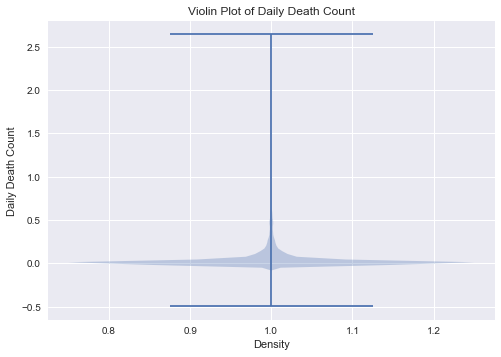

In [83]:
fig, axs = plt.subplots()
axs.violinplot(combo_df[~combo_df["deaths_per_100k_smoothed_ecdc"].isna()]["deaths_per_100k_smoothed_ecdc"])
axs.set_title("Violin Plot of Daily Death Count")
axs.set_xlabel("Density")
axs.set_ylabel("Daily Death Count")
plt.show()

Plot Stringency Index vs Death for the countries with the most cases and a random selection of others

In [84]:
total_cases_by_country = total_cases_by_country.sort_values(ascending=False)
display(total_cases_by_country.shape)
display(total_cases_by_country.head())

select_countries = (list(total_cases_by_country[total_cases_by_country > 10e3].index[:6]) + 
                ["CAN", "CHN", "TWN", "AUS", "NZL", "NGA"])

combo_small_df = combo_df[(combo_df["popData2019"] > 1e6) &
                         (combo_df["iso_code"].isin(select_countries))]

display(combo_small_df.shape)
display(select_countries)
display(combo_small_df["countriesAndTerritories"].nunique())

(210,)

countryterritoryCode
USA    4234020
BRA    2419091
IND    1435453
RUS     812485
ZAF     445433
Name: cases, dtype: int64

(2033, 51)

['USA',
 'BRA',
 'IND',
 'RUS',
 'ZAF',
 'MEX',
 'CAN',
 'CHN',
 'TWN',
 'AUS',
 'NZL',
 'NGA']

12

combo_df[combo_df["countriesAndTerritories"

In [85]:
total_cases_by_country[total_cases_by_country > 10e3].index[-6:-1]

Index(['DNK', 'PSE', 'SDN', 'BGR', 'MKD'], dtype='object', name='countryterritoryCode')

In [86]:
total_cases_by_country[total_cases_by_country.index == "TWN"]

countryterritoryCode
TWN    462
Name: cases, dtype: int64

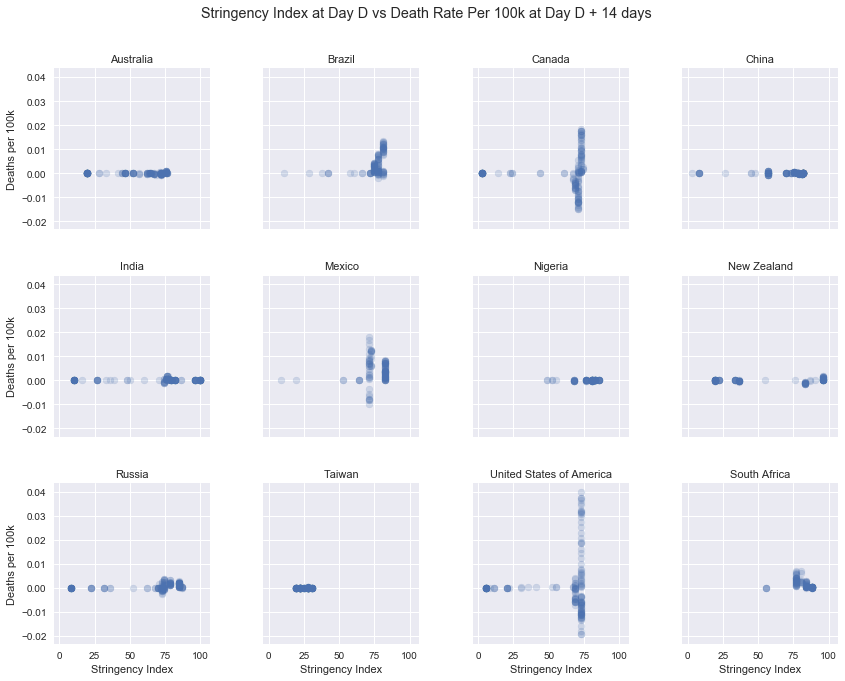

In [87]:
# We don't get much out of this other than to reinforce that the stringency index can stay constant for a while
# and the death rate will move.
g = sns.FacetGrid(combo_small_df, col="countriesAndTerritories", col_wrap=4)
g.map(plt.scatter, "StringencyIndex_lag14d", "death_rate_per_100k_per_day_lag14d_ecdc", alpha=0.2)
g.set_ylabels("Deaths per 100k")
g.set_xlabels("Stringency Index")
g.fig.suptitle('Stringency Index at Day D vs Death Rate Per 100k at Day D + 14 days', y=1.05)
g.set_titles("{col_name}")
plt.show()

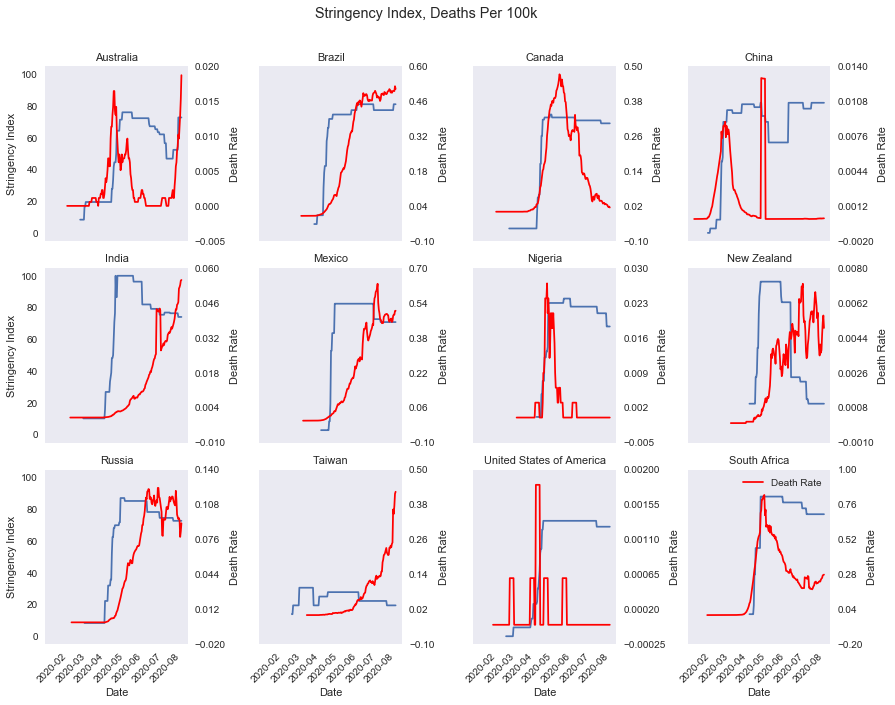

In [88]:
# stolen from https://stackoverflow.com/questions/52945893/python-use-two-y-axis-for-line-and-bar-plots-on-seaborn-facetgrid

g = sns.FacetGrid(combo_small_df, col="countriesAndTerritories", col_wrap=4, legend_out=True)
g = g.map(plt.plot, "dateRepFormat", "StringencyIndex_lag21d", label="Stringency")

for ax, (_, subdata) in zip(g.axes, combo_small_df.groupby('countriesAndTerritories')):
    ax2=ax.twinx()
    ax2.plot(subdata["dateRepFormat"], subdata["deaths_per_100k_smoothed_ecdc"], color="red", label="Death Rate")
    # ADD THIS LINE
    tick_num = len(ax.get_yticks()[(ax.get_yticks() >= 0) & (ax.get_yticks() <= 100)])
#     print(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
    ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], tick_num))
    ax2.set_ylabel("Death Rate")
    ax2.grid(False)
    ax.grid(False)

g.set_xlabels("Date")
g.set_ylabels("Stringency Index")
g.fig.suptitle('Stringency Index, Deaths Per 100k', y=1.05)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)

plt.subplots_adjust(wspace = 0.5)
plt.grid(False)
plt.legend()
plt.show()

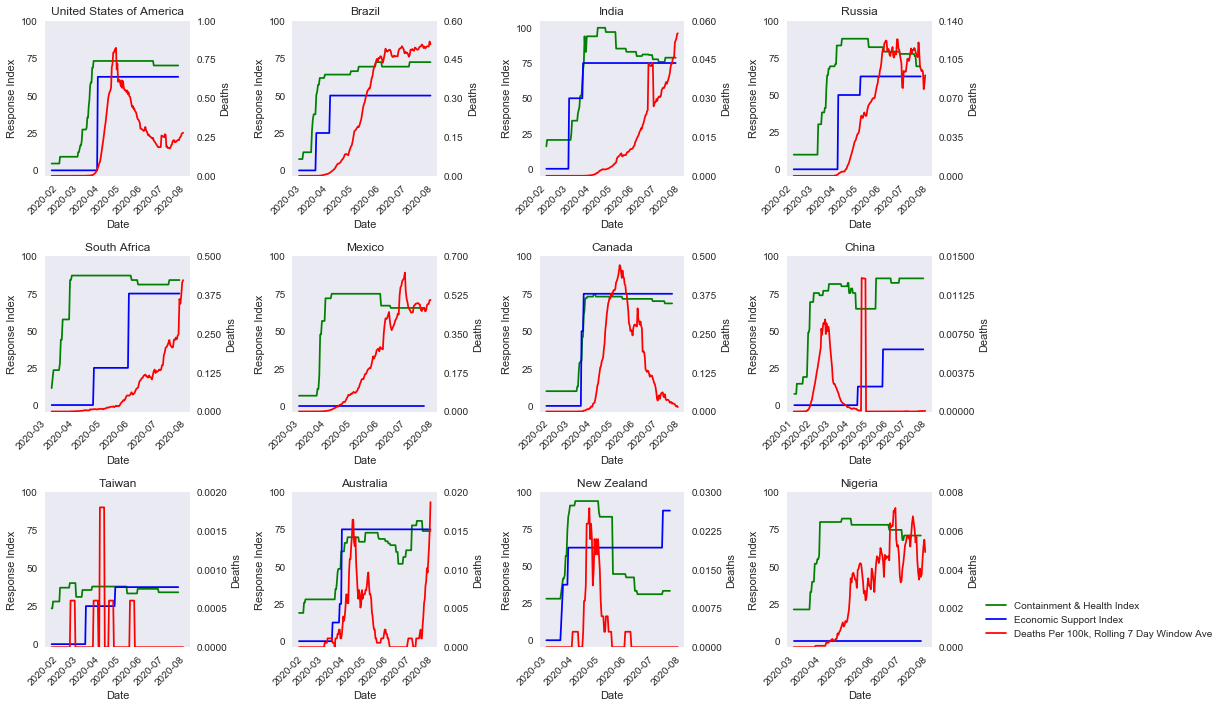

In [89]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(14, 10))

for i, ax in enumerate(axs.flatten()):
    country_df = combo_small_df.loc[combo_small_df["iso_code"] == select_countries[i]]
    
    
    ax.plot(country_df["dateRepFormat"], country_df["ContainmentHealthIndex"], 
            color="green", label="Containment Index")
    ax.plot(country_df["dateRepFormat"], country_df["EconomicSupportIndex"],
            color="blue", label="Economic Support Index")
    
    ax2=ax.twinx()
    ax2.plot(country_df["dateRepFormat"], country_df["deaths_per_100k_smoothed_ecdc"], 
             color="red", label="Deaths Per 100k, Rolling 7 Day Window Ave")
    
    ax.set_yticks(np.linspace(0, 100, 5))
    tick_num = len(ax.get_yticks())
    ax2.set_yticks(np.linspace(0, ax2.get_yticks()[-1], tick_num))
    ax2.set_ylim(0, ax2.get_yticks()[-1])
    ax2.set_ylabel("Deaths")
    ax.set_ylabel("Response Index")
    ax2.grid(False)
    ax.grid(False)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    ax.set_title(country_df["countriesAndTerritories"].iloc[0])
    ax.set_xlabel("Date")
    

plt.subplots_adjust(wspace = 0.5)

legend_elements = [Line2D([0], [0], color='green', label='Containment & Health Index'),
                   Line2D([0], [0], color='blue', label='Economic Support Index'),
                   Line2D([0], [0], color='red', label='Deaths Per 100k, Rolling 7 Day Window Ave')
                  ]
lgd = plt.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(3, 0))
# plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig("response_index_deaths_vs_time_worst12.png",  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Mixed Model Regression

In [90]:
filt_data = combo_df.loc[~combo_df["death_rate_per_100k_per_day_ecdc"].isna() &
                         ~combo_df["death_rate_per_100k_per_day_lag14d_ecdc"].isna() &
                        ~combo_df["StringencyIndex_lag14d"].isna()]

model_si14 = smf.mixedlm("death_rate_per_100k_per_day_ecdc ~ StringencyIndex_lag14d + death_rate_per_100k_per_day_lag14d_ecdc", 
                 filt_data, 
                 groups=filt_data["iso_code"])
model_si14_fit = model_si14.fit()
print(model_si14_fit.summary())
print("Covariate Pvalues:\n")
print(model_si14_fit.pvalues)

print("\nBenjamini Hochberg Adjusted Pvalues:\n")
print(smstats.multitest.multipletests(pvals=model_si14_fit.pvalues, 
                                          alpha=0.05,
                                          method="fdr_bh")[1])

model_si14_aic = smtools.eval_measures.aic(model_si14_fit.llf,
                                   model_si14_fit.nobs,
                                   model_si14_fit.df_modelwc)
print("\nAIC:\n")
print(model_si14_aic)

                      Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  death_rate_per_100k_per_day_ecdc
No. Observations:   18097    Method:              REML                            
No. Groups:         156      Scale:               0.0001                          
Min. group size:    46       Likelihood:          59641.8786                      
Max. group size:    182      Converged:           Yes                             
Mean group size:    116.0                                                         
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                0.002    0.000  5.193 0.000  0.001  0.002
StringencyIndex_lag14d                  -0.000    0.000 -4.078 0.000 -0.000 -0.000
death_rate_per_100k_per_day

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [91]:
filt_data = combo_df.loc[~combo_df["death_rate_per_100k_per_day_ecdc"].isna() &
                         ~combo_df["death_rate_per_100k_per_day_lag14d_ecdc"].isna() &
                        ~combo_df["StringencyIndex_lag21d"].isna()]


model_si21 = smf.mixedlm("death_rate_per_100k_per_day_ecdc " + 
                    "~ StringencyIndex_lag21d " + 
                    "+ death_rate_per_100k_per_day_lag14d_ecdc", 
                 filt_data, 
                 groups=filt_data["iso_code"])
model_si21_fit = model_si21.fit()
print(model_si21_fit.summary())
print("Covariate Pvalues:\n")
print(model_si21_fit.pvalues)

print("\nBenjamini Hochberg Adjusted Pvalues:\n")
print(smstats.multitest.multipletests(pvals=model_si21_fit.pvalues, 
                                          alpha=0.05,
                                          method="fdr_bh")[1])


model_si21_aic = smtools.eval_measures.aic(model_si21_fit.llf,
                                   model_si21_fit.nobs,
                                   model_si21_fit.df_modelwc)
print("\nAIC:\n")
print(model_si21_aic)

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                       Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  death_rate_per_100k_per_day_ecdc
No. Observations:    18104    Method:              REML                            
No. Groups:          156      Scale:               0.0001                          
Min. group size:     46       Likelihood:          59760.1681                      
Max. group size:     182      Converged:           Yes                             
Mean group size:     116.1                                                         
-----------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                0.004    0.000  13.587 0.000  0.004  0.005
StringencyIndex_lag21d                  -0.000    0.000 -13.819 0.000 -0.000 -0.000
death_rate_per_

In [92]:
filt_data = combo_df.loc[~combo_df["death_rate_per_100k_per_day_ecdc"].isna() &
                         ~combo_df["death_rate_per_100k_per_day_lag14d_ecdc"].isna() &
                        ~combo_df["StringencyIndex_lag28d"].isna()]

model_si28 = smf.mixedlm("death_rate_per_100k_per_day_ecdc ~ StringencyIndex_lag28d + death_rate_per_100k_per_day_lag14d_ecdc", 
                 filt_data, 
                 groups=filt_data["iso_code"])
model_si28_fit = model_si28.fit()
print(model_si28_fit.summary())
print("Covariate Pvalues:\n")
print(model_si28_fit.pvalues)

print("\nBenjamini Hochberg Adjusted Pvalues:\n")
print(smstats.multitest.multipletests(pvals=model_si28_fit.pvalues, 
                                          alpha=0.05,
                                          method="fdr_bh")[1])


model_si28_aic = smtools.eval_measures.aic(model_si28_fit.llf,
                                   model_si28_fit.nobs,
                                   model_si28_fit.df_modelwc)
print("\nAIC:\n")
print(model_si28_aic)


print("\nModel Coefficients:\n")
print(model_si28_fit.params)

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                       Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  death_rate_per_100k_per_day_ecdc
No. Observations:    18103    Method:              REML                            
No. Groups:          156      Scale:               0.0001                          
Min. group size:     46       Likelihood:          59950.2330                      
Max. group size:     181      Converged:           Yes                             
Mean group size:     116.0                                                         
-----------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                0.006    0.000  20.957 0.000  0.005  0.006
StringencyIndex_lag28d                  -0.000    0.000 -24.049 0.000 -0.000 -0.000
death_rate_per_

In [93]:
filt_data = combo_df.loc[~combo_df["death_rate_per_100k_per_day_ecdc"].isna() &
                         ~combo_df["death_rate_per_100k_per_day_lag14d_ecdc"].isna() &
                         ~combo_df["EconomicSupportIndex_lag28d"].isna() &
                         ~combo_df["ContainmentHealthIndex_lag28d"].isna()
                        ]

model_gov_econ_con = smf.mixedlm("death_rate_per_100k_per_day_ecdc ~ " + 
                    "death_rate_per_100k_per_day_lag14d_ecdc " + 
                    "+ EconomicSupportIndex_lag28d " + 
                    "+ ContainmentHealthIndex_lag28d", 
                 filt_data, 
                 groups=filt_data["iso_code"])
model_model_gov_econ_con_fit = model_gov_econ_con.fit()
print(model_model_gov_econ_con_fit.summary())

print("Covariate Pvalues:\n")
print(model_model_gov_econ_con_fit.pvalues)

print("\nBenjamini Hochberg Adjusted Pvalues:\n")
print(smstats.multitest.multipletests(pvals=model_model_gov_econ_con_fit.pvalues, 
                                          alpha=0.05,
                                          method="fdr_bh")[1])

model_model_gov_econ_con_aic = smtools.eval_measures.aic(model_model_gov_econ_con_fit.llf,
                                   model_model_gov_econ_con_fit.nobs,
                                   model_model_gov_econ_con_fit.df_modelwc)
print("\nAIC:\n")
print(model_model_gov_econ_con_aic)

print("\nCoefficients:\n")
print(model_model_gov_econ_con_fit.params)

                       Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  death_rate_per_100k_per_day_ecdc
No. Observations:    18086    Method:              REML                            
No. Groups:          156      Scale:               0.0001                          
Min. group size:     46       Likelihood:          59885.4102                      
Max. group size:     181      Converged:           Yes                             
Mean group size:     115.9                                                         
-----------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                0.006    0.000  19.403 0.000  0.005  0.006
death_rate_per_100k_per_day_lag14d_ecdc  0.161    0.008  20.748 0.000  0.146  0.176
EconomicSupport

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


With the per-country random effects in all of our mixed models, we already take into account the offset and variation due to country-wide variables such as socioeconomic issues and health infrastructure.  However, we create another model with these variables explicit so that we can compare their effects on mortality.

The effects of percentage of elderly, extreme poverty are significant on the mortality rate.  However, diabetes and hospital beds per capita are not.

In [94]:
filt_data = combo_df.loc[~combo_df["death_rate_per_100k_per_day_ecdc"].isna() &
                         ~combo_df["death_rate_per_100k_per_day_lag14d_ecdc"].isna() &
                        ~combo_df["StringencyIndex_lag28d"].isna() &
                         ~combo_df["aged_65_older"].isna() &
                         ~combo_df["diabetes_prevalence"].isna() &
                         ~combo_df["extreme_poverty"].isna() &
                         ~combo_df["hospital_beds_per_thousand"].isna()
                        ]

model_sociecon = smf.mixedlm("death_rate_per_100k_per_day_ecdc ~ " + 
                            "death_rate_per_100k_per_day_lag14d_ecdc " + 
                            "+ StringencyIndex_lag28d " + 
                            "+ aged_65_older " + 
                            "+ diabetes_prevalence" + 
                             "+ extreme_poverty" + 
                             "+ hospital_beds_per_thousand"
                             , 
                 filt_data, 
                 groups=filt_data["iso_code"])
model_sociecon_fit = model_sociecon.fit()
print(model_sociecon_fit.summary())

print("Covariate Pvalues:\n")
print(model_sociecon_fit.pvalues)

print("\nBenjamini Hochberg Adjusted Pvalues:\n")
print(smstats.multitest.multipletests(pvals=model_sociecon_fit.pvalues, 
                                          alpha=0.05,
                                          method="fdr_bh")[1])

model_sociecon_fit_aic = smtools.eval_measures.aic(model_sociecon_fit.llf,
                                   model_sociecon_fit.nobs,
                                   model_sociecon_fit.df_modelwc)
print("\nAIC:\n")
print(model_sociecon_fit_aic)

                       Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  death_rate_per_100k_per_day_ecdc
No. Observations:    11185    Method:              REML                            
No. Groups:          95       Scale:               0.0001                          
Min. group size:     60       Likelihood:          35196.2488                      
Max. group size:     181      Converged:           Yes                             
Mean group size:     117.7                                                         
-----------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                0.010    0.001   9.065 0.000  0.008  0.013
death_rate_per_100k_per_day_lag14d_ecdc  0.177    0.010  17.758 0.000  0.157  0.197
StringencyIndex

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


 According to the lowest (aka best) AIC, the better model is the one where we don't split up the Stringency Index

In [95]:
#
np.argmin([model_si14_aic, model_si21_aic, model_si28_aic, model_sociecon_fit_aic, model_model_gov_econ_con_aic])

2

Plot the residuals vs the fitted values for the best model.
The residuals seem a bit skewed, but best fit line seems to be straight.

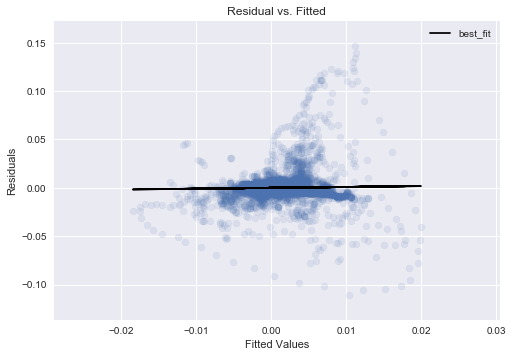

In [96]:
filt_data = combo_df.loc[~combo_df["death_rate_per_100k_per_day_ecdc"].isna() &
                         ~combo_df["death_rate_per_100k_per_day_lag14d_ecdc"].isna() &
                        ~combo_df["StringencyIndex_lag28d"].isna()]

plt.scatter(filt_data['death_rate_per_100k_per_day_ecdc'] - model_si28_fit.resid, 
            model_si28_fit.resid, alpha = 0.1) 
plt.title("Residual vs. Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

m, b = np.polyfit(filt_data['death_rate_per_100k_per_day_ecdc'] - model_si28_fit.resid, model_si28_fit.resid, 1)
plt.plot(filt_data['death_rate_per_100k_per_day_ecdc'] - model_si28_fit.resid, 
         m*(filt_data['death_rate_per_100k_per_day_ecdc'] - model_si28_fit.resid) + b,
        label="best_fit", color="black")

plt.legend()
plt.show()